# Navigation

---

This notebook is an implementation of deep Q-networks for Udacity's excellent [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### Start the Environment

If the code cell below returns an error, please check you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
import torch
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
check_GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
check_GPU

device(type='cuda', index=0)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(brain_name, brain)

BananaBrain Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [5]:
# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# Number of agents in the environment
print('Number of agents:', len(env_info.agents))

# Number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# Examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Training the Agent

In [6]:
from agent import Agent

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, checkpoint_filename='checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #agent = Agent(state_size=37, nn_type, action_size=4, seed=0)
    scores = []                        # List containing scores from each episode
    scores_window = deque(maxlen=100)  # Last 100 scores
    eps = eps_start                    # Initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # Reset the environment
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps) # Initialize action
            env_info = env.step(int(action))[brain_name] 
            next_state = env_info.vector_observations[0] # Take next step
            reward = env_info.rewards[0] # Obtain reward
            done = env_info.local_done[0] # If completed (breakpoint below)
            
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break 
                
        scores_window.append(score)       # Save most recent score
        scores.append(score)              # Save most recent score
        eps = max(eps_end, eps_decay*eps) # Decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)
            break
    return scores


In [10]:
from model import *
vanilla_agent = Agent(nn_type=QNetwork.dqn_type,
              state_size=state_size, 
              action_size=action_size, 
              seed=0)
scores = dqn(vanilla_agent, n_episodes=2000, checkpoint_filename='vanilla_checkpoint.pth')

Episode 100	Average Score: 1.19
Episode 200	Average Score: 4.75
Episode 300	Average Score: 7.87
Episode 400	Average Score: 10.03
Episode 500	Average Score: 12.79
Episode 507	Average Score: 13.03
Environment solved in 407 episodes!	Average Score: 13.03


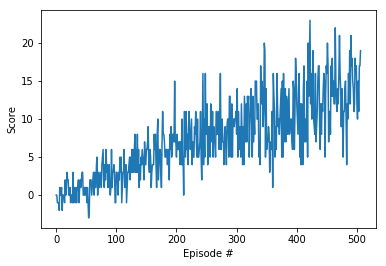

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
env_info = env.reset(train_mode=False)[brain_name] # Reset environment

# Initialize agent with state and action size 
vanilla_agent = Agent(nn_type=QNetwork.dqn_type, state_size=state_size, action_size=action_size, seed=0)

# Load trained weights
vanilla_agent.qnetwork_local.load_state_dict(torch.load('vanilla_checkpoint.pth'))

In [18]:
state = env_info.vector_observations[0]  # Get the starter state
score = 0 # Initialization
while True:  
    action = vanilla_agent.act(state, 0) # Select greedy action
    env_info = env.step(int(action))[brain_name] # Execute action
    score += env_info.rewards[0] # Update score with reward from that action
    next_state = env_info.vector_observations[0] # Set up next state
    state = next_state # Set current state to next state
    done = env_info.local_done[0] # 'Done' boolean completes the episode
    if done:
        break
        
print("Score: {}".format(score)) 

env.close() # Close the environment

Score: 14.0


In [7]:
from model import *
duelling_agent = Agent(nn_type=QNetwork.dqn_type,
              state_size=state_size, 
              action_size=action_size, 
              seed=0)
scores = dqn(duelling_agent, n_episodes=2000, checkpoint_filename='duelling_checkpoint.pth')

Episode 100	Average Score: 1.29
Episode 200	Average Score: 4.58
Episode 300	Average Score: 8.08
Episode 400	Average Score: 10.22
Episode 500	Average Score: 12.56
Episode 547	Average Score: 13.00
Environment solved in 447 episodes!	Average Score: 13.00


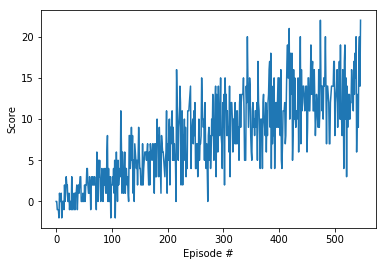

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env_info = env.reset(train_mode=False)[brain_name] # Reset environment

# Initialize agent with state and action size 
duelling_agent = Agent(nn_type=QNetwork.dqn_type, state_size=state_size, action_size=action_size, seed=0)

# Load trained weights
duelling_agent.qnetwork_local.load_state_dict(torch.load('duelling_checkpoint.pth'))

In [12]:
state = env_info.vector_observations[0]  # Get the starter state
score = 0 # Initialization
while True:  
    action = duelling_agent.act(state, 0) # Select greedy action
    env_info = env.step(int(action))[brain_name] # Execute action
    score += env_info.rewards[0] # Update score with reward from that action
    next_state = env_info.vector_observations[0] # Set up next state
    state = next_state # Set current state to next state
    done = env_info.local_done[0] # 'Done' boolean completes the episode
    if done:
        break
        
print("Score: {}".format(score)) 

env.close() # Close the environment

Score: 23.0
